# Assignment 06

Joel Brigida

CAP4613-001 Intro to Deep Learning

Prof. Behnaz Ghoraani

Due Date: April 17, 2023

#### Turn Off Messages & Set GPU Memory Growth:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Turn Off Messages
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Check GPU Availibility & Set Memory Limit:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]) # Alt: 1792 MB, 2048 MB
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Import Libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from random import randint
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical

#### Functions To Plot Images:

In [4]:
def dispAnImage(filepath):
    myImage = img.imread(filepath)
    plt.figure(figsize = (15, 15))
    plt.imshow(myImage)
    plt.axis('off') # Turn Off Axes for image display
    plt.show()

def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

# Plot Features of CIFAR-10 data
def feat_plot(features, labels, classes, title):
    for class_i in classes:
        plt.plot(features[labels[:] == classes[class_i], 0],
                 features[labels[:] == classes[class_i], 1], 'o', markersize = 5)
        # plt.axis([-2, 2, -2, 2])
        plt.xlabel('X: Feature 1')
        plt.ylabel('Y: Feature 2')
        plt.title(title)
        plt.legend(['Class ' + str(classes[class_i]) for class_i in classes])
    plt.show()

# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss, supTitle):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [13, 7])
    plt.suptitle(supTitle)
    plt.tight_layout()
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

def plotBothCurves(trainingAccuracy, trainingLoss, validAccuracy, validLoss):
    epochs = np.arange(trainingLoss.shape[0])
    epochsSaved = np.arange(validLoss.shape[0])
    #print(epochs)
    # 1st Subplot: Accuracy
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    plt.plot(epochsSaved, validAccuracy) # Saved Best Value
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    # 2nd Subplot: Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.plot(epochsSaved, validLoss)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot CIFAR-10 Data In Subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

def plotEverything(model_hist):
    trainAcc = np.array(model_hist.history['accuracy'])
    trainLoss = np.array(model_hist.history['loss'])
    validAcc = np.array(model_hist.history['val_accuracy'])
    validLoss = np.array(model_hist.history['val_loss'])

    plotBothCurves(trainAcc, trainLoss, validAcc, validLoss)

    trainScore = [trainAcc[-1], trainLoss[-1]]
    print(f'\nTraining Accuracy: {round(trainScore[0], 5) * 100} %')
    print(f'Training Loss: {round(trainScore[1], 4)}\n')

    valScore = [validAcc[-1], validLoss[-1]]
    print(f'\nValidation Accuracy: {round(valScore[0], 5) * 100} %')
    print(f'Validation Loss: {round(valScore[1], 4)}\n')

## Problem 1) Consider the Convolutional Layer Below: 
 - Fill in the Missing cells in the activation map and output image.

 <div align="center">

Input Image
|  |  |  |  |  |  |  |  |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| $0.81$ | $0.90$ | $0.13$ | $0.91$ | $0.63$ | $0.09$ | $0.28$ | $0.54$ |
| $0.96$ | $0.96$ | $0.15$ | $0.97$ | $0.96$ | $0.48$ | $0.14$ | $0.80$ |
| $0.42$ | $0.91$ | $0.79$ | $0.22$ | $0.66$ | $0.03$ | $0.84$ | $0.93$ |
| $0.67$ | $0.75$ | $0.74$ | $0.39$ | $0.65$ | $0.17$ | $0.71$ | $0.03$ |
| $0.27$ | $0.04$ | $0.09$ | $0.82$ | $0.69$ | $0.31$ | $0.95$ | $0.03$ |
| $0.43$ | $0.38$ | $0.76$ | $0.79$ | $0.19$ | $0.49$ | $0.45$ | $0.64$ |
| $0.70$ | $0.75$ | $0.28$ | $0.68$ | $0.66$ | $0.16$ | $0.12$ | $0.49$ |
| $0.36$ | $0.45$ | $0.58$ | $0.22$ | $0.75$ | $0.25$ | $0.51$ | $0.69$ |

<br>

Conv Layer, ReLU: 1 Filter of $5 \times 5 \times 1$
|  |  |  |  |  |
| :-: | :-: | :-: | :-: | :-: |
| $-1$ | $0$ | $0$ | $0$ | $0$ |
| $0$ | $1$ | $0$ | $0$ | $0$ |
| $0$ | $0$ | $-1$ | $0$ | $0$ |
| $0$ | $0$ | $0$ | $1$ | $0$ |
| $0$ | $0$ | $0$ | $0$ | $1$ |

<br>

Activation Map:
|  |  |  |  |
| :-: | :-: | :-: | :-: |
| $0.44$ | $-0.01$ | $1.3$ | $0.76$ |
| $0.22$ | $0.62$ | $0.18$ | $1.11$ |
| $1.69$ | $-0.64$ | $-0.48$ | $1.06$ |
| $0.04$ | $-0.54$ | $0.56$ | $0.62$ |

<br>

Output Image:
|  |  |  |  |
| :-: | :-: | :-: | :-: |
| $0.44$ | $0$ | $1.3$ | $0.76$ |
| $0.22$ | $0.62$ | $0.18$ | $1.11$ |
| $1.69$ | $0$ | $0$ | $1.06$ |
| $0.04$ | $0$ | $0.56$ | $0.62$ |

</div>

#### Show Handwritten Work:

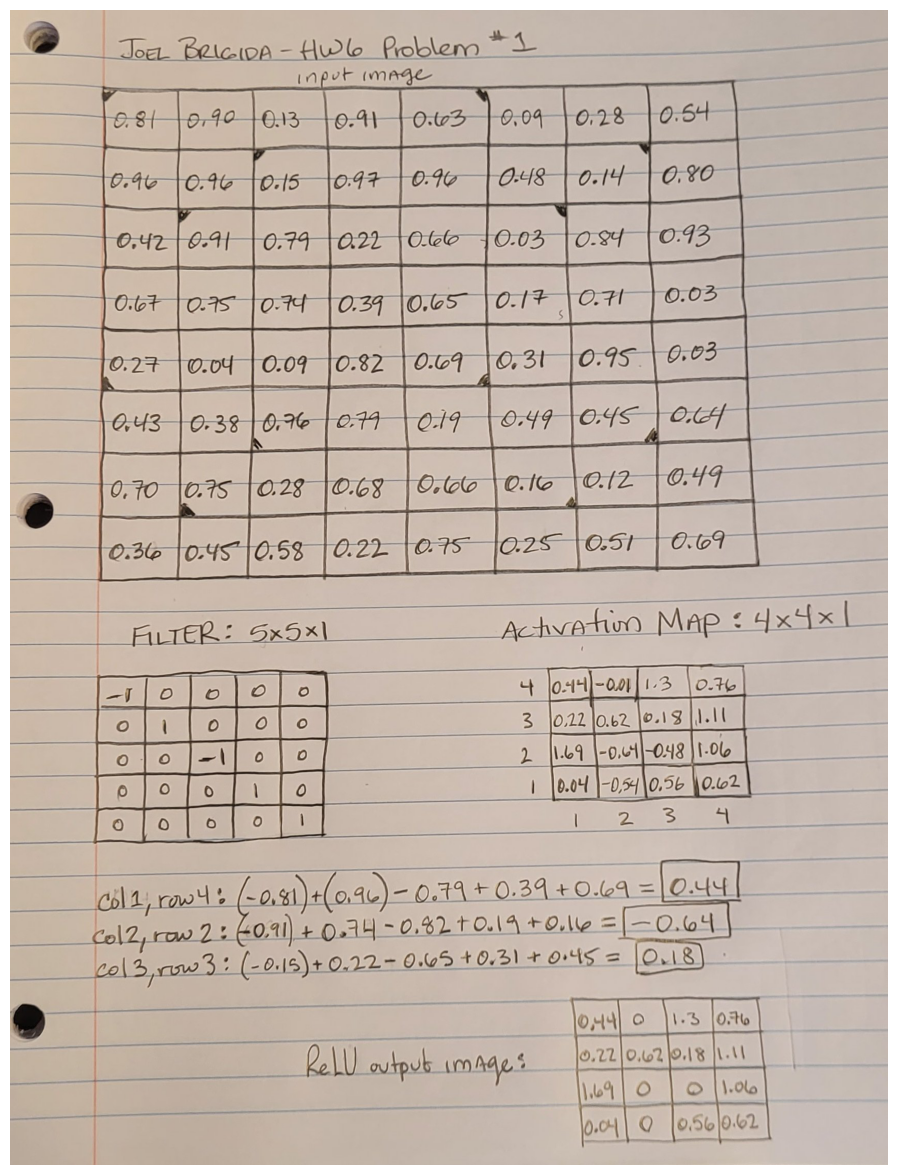

In [5]:
dispAnImage('../assets/HW6/Prob1-Soln.jpg')

## Problem 2) Consider the following CNN:
 - The input images are of the size $ 65 \times 65 \times 3 $ and the problem is a 10-class classification.
 - Answer the following questions. Show all steps in your calculation.

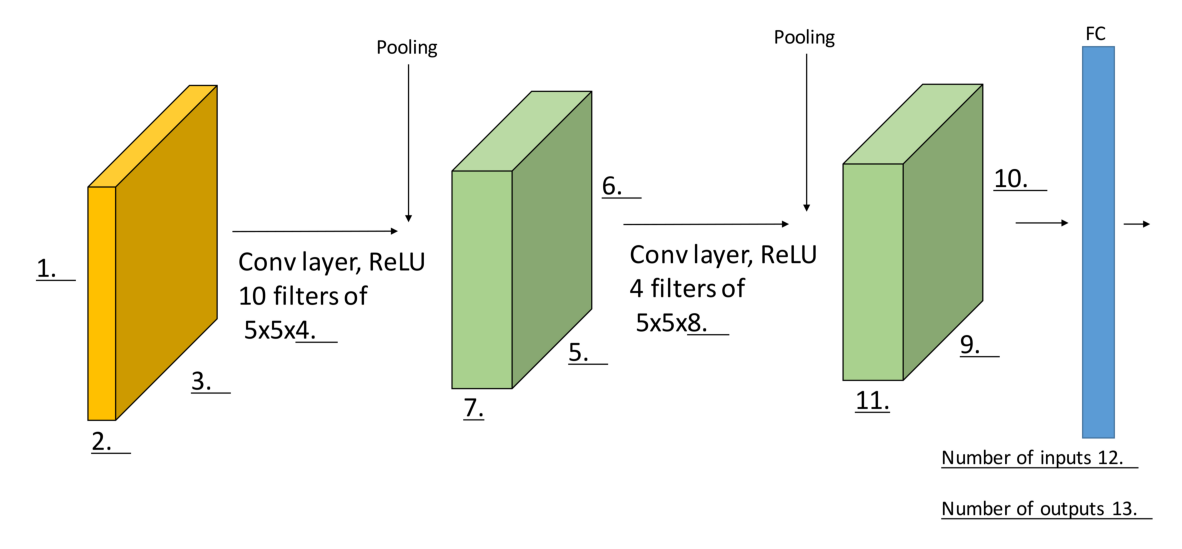

In [6]:
dispAnImage('../assets/HW6/Prob2.png')

#### 2a) Padding of 1 and stride of 2 in Conv 1; padding of 2 and stride of 1 in Conv 2. Find and report the values in the spaces 1. to 13.

#### 2b) Calculate the number of total parameters at every Conv and fully connected (FC) layer.

#### 2c) Find the total number of parameters of the entire neural network.

In [ ]:
#dispAnImage()

## Problem 3) Keras: Convolutional Neural Network (CNN), 10-class classifier for CIFAR-10 dataset:

 - a) Use `cifar10` function in `keras.datasets` to load CIFAR-10 dataset. Split it into the training and testing sets. Define a validation set by randomly selecting 20% of the training images along with their corresponding labels. This will be the `validation_data`.
 - b) Scale the pixel values of the images in all the sets to a value between 0 and 1. Perform this process by dividing the image values with 255. Note: No need to flatten the images.
 - c) Convert the label vectors for all the sets to binary class matrices using `to_categorical()` Keras function.
 - d) Using Keras library, build a CNN with the following design: 2 convolutional blocks, 1 flattening layer, 1 FC layer with 512 nodes, and 1 output layer. Each convolutional block consists of two back-to-back Conv layers followed by max pooling. The filter size is $3 \times 3$ image_depth. The number of filters is 32 in the first convolutional block and 64 in the second block. Use the following network architecture as a reference:

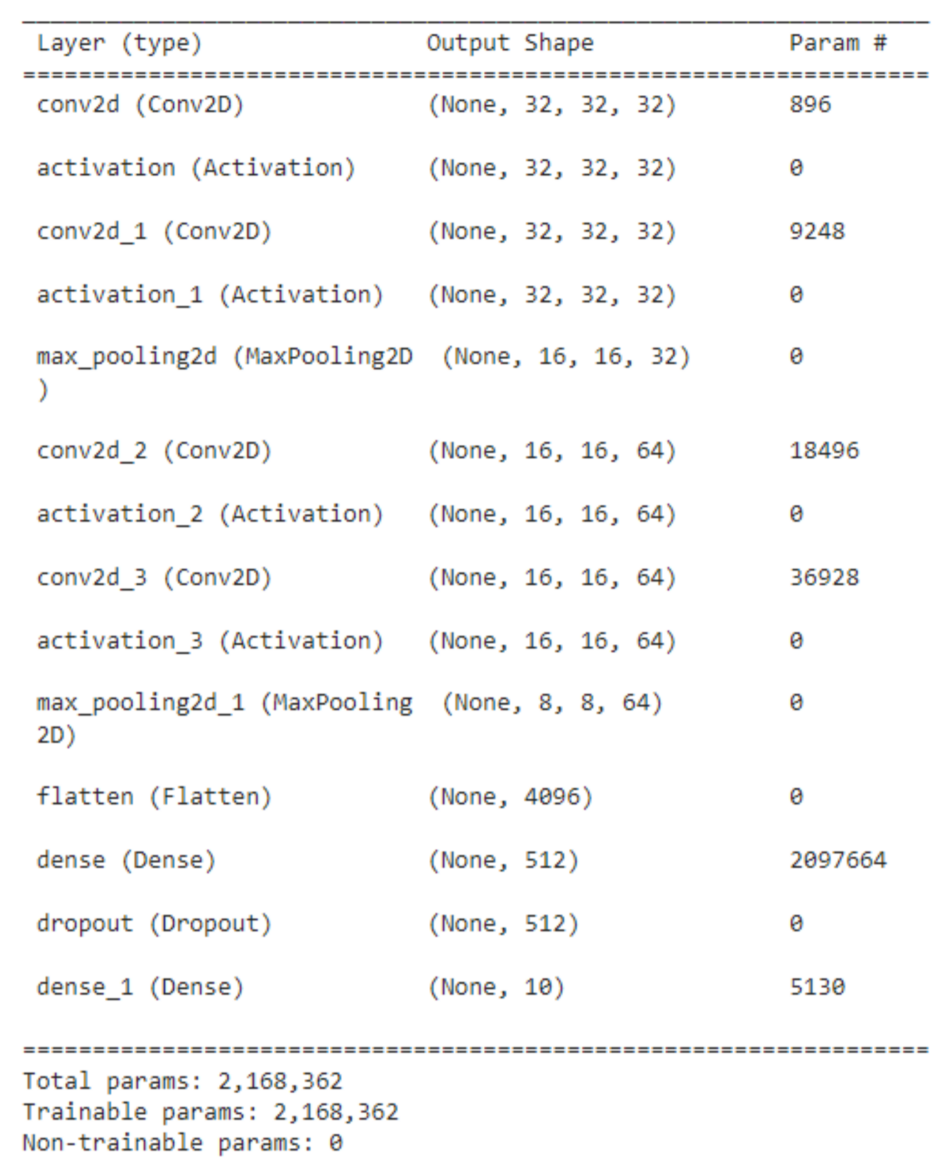

In [9]:
dispAnImage('../assets/HW6/Prob3.png')

e) Compile, train, and then evaluate:
 - i. Compile the network. Make sure to select a correct loss function for this classification problem. Use `Adam` optimizer (Adam: learning rate of $0.001$).
 - ii. Use `ModelCheckpoint` to save the best model based on the lowest validation loss.
 - iii. Train the network for 50 epochs with a batch size of 32. Remember to assign the validation set to `validation_data` in the fit function.
 - iv. Plot the training and validation loss for all the epochs in one plot. 
 - v. Use the `evaluate()` Keras function to find the training and validation loss and the accuracy. Report the results.

f) Now define another model with the same architecture in (d) and then:
 - i. Compile the network. Make sure to select a correct loss function for this classification problem. Use `Adam` optimizer (Adam: learning rate of $0.001$).
 - ii. Use `ModelCheckpoint` to save the best model based on the lowest validation loss.
 - iii. Create an image data generator in Keras for real-time data augmentation. The augmentation operations are rotation (10 degrees range), width and height. shift (0.1 range), and horizontal flip.
 - iv. Train the network for 50 epochs with a batch size of 32. Remember to use the image data generator. Assign the validation set to `validation_data` in the fit function.
 - v. Plot the training and validation loss for all the epochs in one plot. 
 - vi. Use the `evaluate()` Keras function to find the training and validation loss and the accuracy. Report the results.

g) What do you observe from the validation loss in both step (e) and (f)? Is the model overfitting or underfitting the training data? Explain.

h) Now define another model with the same architecture in (d), except that this time you need to add batch normalization layers to the CNN network.
 - i. Add normalization layer after all the convolutional and fully connected layers (not the output layer). Add them before the activation layers and be noted that there is no need for the bias in the convolutional or fully connected layers.
 - ii. Compile the network. Make sure to select a correct loss function for this classification problem. Use `Adam` optimizer (Adam: learning rate of $0.01$).
 - iii. Use `ModelCheckpoint` to save the best model based on the lowest validation loss.
 - iv. Train the network for 50 epochs with a batch size of 64. Remember to assign the validation set to `validation_data` in the fit function.
 - v. Plot the training and validation loss for all the epochs in one plot.
 - vi. Use the `evaluate()` Keras function to find the training and validation loss and

i) What do you observe from the training loss in both steps (e) and (h)? Explain.